# TF-IDF Analysis

TF-IDF (term frequency-inverse document frequency) analysis is a statistical technique used in natural language processing and information retrieval to determine the importance of a word in a document or corpus. It is a way to measure how relevant a word is to a document in a collection of documents.

TF-IDF analysis assigns a weight to each word in a document based on how frequently it appears in the document (term frequency) and how rare it is in the entire corpus (inverse document frequency). The weight assigned to a word increases proportionally with its frequency in the document, but is offset by the rarity of the word in the corpus. This means that words that appear frequently in a document but also appear frequently in many other documents in the corpus are given a lower weight, while words that appear less frequently in the corpus but frequently in a particular document are given a higher weight.

The output of TF-IDF analysis is a numerical representation of each document that captures the importance of each word in that document. This can be used for various tasks such as text classification, clustering, and information retrieval.

## Table of Contents
* [Connect to Database ](#Connect-to-database)
* [Import Datasets](#Import-Dataset)
* [Remove Stopwords](#Remove-stopwords)
* [Lemmatization](#Lemmatization)

## Connect to Database

In [1]:
import mysql.connector
import pandas as pd

#creds = ["username","password","juliehaegh","ninG20&19rea","3306"] 
creds = ["juliehaegh","ninG20&19rea","172.20.20.4","hgo",3306]

In [2]:
#Connection to the database
host = creds[2]
user = creds[0]
password = creds[1]
database = creds[3]
port = creds[4]
mydb = mysql.connector.connect(host=host, user=user, database=database, port=port, password=password, auth_plugin='mysql_native_password')
mycursor = mydb.cursor()

#Safecheck to guarantee that the connection worked
mycursor.execute('SHOW TABLES;')
print(f"Tables: {mycursor.fetchall()}")
print(mydb.connection_id) #it'll give connection_id,if got connected

Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
364


## Import Datasets

In [3]:
# Import Alert P1 dataset
SClinic = pd.read_sql("""SELECT * FROM ConsultaUrgencia_doentespedidosconsultaNeurologia2012""",mydb)

# Import SClinic
AlertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)

# Replace all NaN with 0
AlertP1 = AlertP1.fillna(0)

# Add result column
AlertP1['result'] = ['Accepted' if x in [0,14,25,20,53,8,12,12] else 'Refused' for x in AlertP1['COD_MOTIVO_RECUSA']]

/Users/juliehaegh/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/juliehaegh/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
# Create a new column with accepted and rejected cases
#SClinic['Accepted/Rejected'] = SClinic['COD_MOTIVO_RECUSA'].apply(lambda x: 'Accepted' if x == 0 else 'Rejected')
#SClinic = SClinic[(SClinic['Texto']!='') & (SClinic['Accepted/Rejected']=='Accepted')].iloc[887:987]
#SClinic = SClinic[SClinic['Texto']!='']
#SClinic

In [5]:
import math

# Split data into train and test
AlertP1_sorted = AlertP1[AlertP1['Texto']!=''].sort_values(by='DATA_RECEPCAO')
AlertP1_sorted.DATA_RECEPCAO
# calculate the index for the split
#split_index = math.ceil(0.8 * len(AlertP1_sorted))

# split the data frame into test and train sets
#train_set = AlertP1_sorted.iloc[:split_index]
#test_set = AlertP1_sorted.iloc[split_index:]

1540    01/02/2012
525     01/02/2013
121     01/02/2016
168     01/02/2016
1154    01/03/2012
           ...    
437     31/10/2013
1051    31/10/2013
830     31/10/2014
690     31/10/2016
1698    31/12/2013
Name: DATA_RECEPCAO, Length: 1773, dtype: object

<AxesSubplot:>

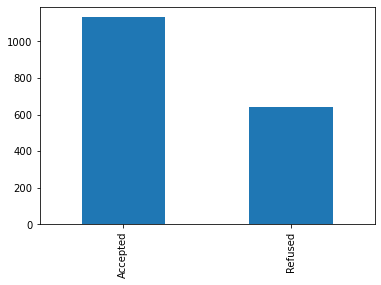

In [6]:
# check the balance of result feature:
AlertP1_sorted['result'].value_counts().plot(kind='bar')

In [7]:
# Import librariers 
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from unidecode import unidecode
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings(action="ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliehaegh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juliehaegh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Remove Stopwords

In [8]:
# Get rid of special characters and transform Texto column to Latin words
#train_set['Texto'] = train_set['Texto'].apply(lambda x: unidecode(x))
#test_set['Texto'] = test_set['Texto'].apply(lambda x: unidecode(x))
AlertP1_sorted['Texto'] = AlertP1_sorted['Texto'].apply(lambda x: unidecode(x))

#The re.sub function is used to substitute all digits (\d) with an empty string
#train_set['Texto'] = train_set['Texto'].apply(lambda x: re.sub(r'\d', '', x))
#test_set['Texto'] = test_set['Texto'].apply(lambda x: re.sub(r'\d', '', x))
AlertP1_sorted['Texto'] = AlertP1_sorted['Texto'].apply(lambda x: re.sub(r'\d', '', x))

# Remove all names in Texto variable
# This function uses a regular expression to find all words in the text that start with a 
# capital letter (\b[A-Z][a-z]+\b), which are assumed to be names
#text = train_set['Texto'] 
text = AlertP1_sorted['Texto'] 

# remove all hyphens from the text
text = text.replace('-', '')

def remove_names(text):
    # Find all words that start with a capital letter
    names = re.findall(r'\b[A-Z][a-z]+\b', text)
    
    # Replace the names with an empty string
    for name in names:
        text = text.replace(name, '')
        
    return text

In [9]:
# Create an empty list to store the text
text_list = []

# Loop through the 'text' column
for text in text.str.lower(): # Transform every word to lower case
    text_list.append(text)

# Print the list of text
#print(text_list)

In [10]:
# Download the Portuguese stop words
nltk.download('stopwords')
nltk.download('punkt')

# Get the Portuguese stop words
stop_words = set(stopwords.words('portuguese'))

# Manually remove stopwords
stop_words.update(['-//','.', ',','(',')',':','-','?','+','/',';','2','1','drª','``','','3','desde','anos','doente','consulta','alterações','se',"''",'cerca','refere','hgo','utente','vossa','s','...','ainda','c','filha','costa','dr.','pereira','ja','--','p','dr','h','n','>','q','//','..','b','++','%','//','-','+++/','=','+++/'])

# Create a new list to store the filtered text
filtered_text = []

# Loop through the text_list and remove the stop words
for text in text_list:
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    filtered_text.append(" ".join(words))

# Print the filtered text
#print(filtered_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juliehaegh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/juliehaegh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# Save the filtered text as a new column to the dataframe
AlertP1_sorted['filtered_text'] = filtered_text

## Lemmatization

Lemmatization is a text normalization technique used in Natural Language Processing (NLP), that switches any kind of a word to its base root mode. Lemmatization is responsible for grouping different inflected forms of words into the root form, having the same meaning

In [12]:
# Define function for lemmatization
def spacy_lemmatizer(df):
    import spacy
    import pt_core_news_md
    nlp = pt_core_news_md.load()

    doclist = list(nlp.pipe(df))

    docs=[]
    for i, doc in enumerate(doclist):
        docs.append(' '.join([listitem.lemma_ for listitem in doc]))
        
    return docs

In [14]:
# create an empty list to store the words
word_list = []

# loop through each row of the "text_column" column
for index, row in AlertP1_sorted.iterrows():
    
    # split the text into individual words using whitespace as a delimiter
    words = row['filtered_text'].split()
    # add the words to the word list
    word_list.extend(words)

# print the word list
#print(word_list)

In [17]:
# create an empty list to store the words
word_list = []

# loop through each row of the "text_column" column
for index, row in AlertP1_sorted.iterrows():
    
    # split the text into individual words using whitespace as a delimiter
    words = row['filtered_text'].split()
    
    # remove hyphens from the words and add them to the word list
    word_list.extend([word.replace('-', '') for word in words])
    # remove slash from the words and ass them to the list
    word_list.extend([word.replace('/', '') for word in words])
    

# print the cleaned word list
#print(word_list)

In [18]:
Lemma = spacy_lemmatizer(word_list) # Call lemmatizer function

# print length of word_list and compare the count after doing lemmatization
from collections import Counter

items = Counter(Lemma).keys()
print('The number of words after lemmatization:',len(items))

items2 = Counter(word_list).keys()
print('The number of words before lemmatization:',len(items2))

The number of words after lemmatization: 9884
The number of words before lemmatization: 12057


In [19]:
# apply the spacy_lemmatizer function to each row in the 'text' column
AlertP1_sorted['text_lemmatized'] = spacy_lemmatizer(AlertP1_sorted['filtered_text'])

# drop rows with empty strings
AlertP1_filtered = AlertP1_sorted[['text_lemmatized','filtered_text','result']].replace('', pd.NA).dropna()
AlertP1_filtered = pd.DataFrame(AlertP1_filtered)
AlertP1_filtered

,text_lemmatized,filtered_text,result
1540,dor lapso efoi-le dar alto qualquer justificac...,dor lapso foi-lhe dada alta qualquer justifica...,Refused
525,relatorio clinico,relatorio clinico,Refused
121,homem ap dm gamapatia monoclonal igm dca arter...,homem ap dm gamapatia monoclonal igm dca arter...,Refused
168,mulher dor ponto lingua sensacao repuxamento l...,mulher dor ponta lingua sensacao repuxamento l...,Refused
1154,epilepsia,epilepsia,Accepted
...,...,...,...
437,queixa tontura episodio perturbacoes equilibri...,queixas tonturas episodios perturbacoes equili...,Accepted
1051,esclerose multiplo,esclerose multipla,Accepted
830,cefaleia parietal intenso nunca desequilibriar...,cefaleia parietal intensa nunca desequilibrio ...,Refused
690,cidp sob corticoterapia,cidp sob corticoterapia,Accepted


In [20]:
refused_referrals = AlertP1_filtered[AlertP1_filtered.result == 'Refused']
refused_referrals.head()

,text_lemmatized,filtered_text,result
1540,dor lapso efoi-le dar alto qualquer justificac...,dor lapso foi-lhe dada alta qualquer justifica...,Refused
525,relatorio clinico,relatorio clinico,Refused
121,homem ap dm gamapatia monoclonal igm dca arter...,homem ap dm gamapatia monoclonal igm dca arter...,Refused
168,mulher dor ponto lingua sensacao repuxamento l...,mulher dor ponta lingua sensacao repuxamento l...,Refused
502,sexo feminino relatar sentir se cada vez esque...,sexo feminino relata sentir-se cada vez esquec...,Refused


In [21]:
accepted_referrals = AlertP1_filtered[AlertP1_filtered.result == 'Accepted']
accepted_referrals.head()

,text_lemmatized,filtered_text,result
1154,epilepsia,epilepsia,Accepted
1151,sintomatologia mulher hipertenso epilepsia .qu...,sintomatologia mulher hipertensa epilepsia .qu...,Accepted
618,sexo masculino ap epilepsia medicar tegretol s...,sexo masculino ap epilepsia medicado tegretol ...,Accepted
782,homem quadro alucinacoes visual bem delinear a...,homem quadro alucinacoes visuais bem delineada...,Accepted
795,perda progressivo equilibrio marchar dificulda...,perda progressiva equilibrio marcha dificuldad...,Accepted


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = AlertP1_filtered.filtered_text
Y = AlertP1_filtered.result

vect = TfidfVectorizer()
X = vect.fit_transform(AlertP1_filtered.filtered_text)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state=42)

print('Size of x_train: ', (x_train.shape))
#print('Size of y_train: ,' (y_train.shape))
print('Size of x_test: ', (x_test.shape))
#print('Size of y_test: ,' (y_test.shape))

Size of x_train:  (1414, 10323)
Size of x_test:  (354, 10323)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print('Test accuracy: {:.2f}%'. format(logreg_acc*100))

Test accuracy: 72.88%


In [24]:
print(confusion_matrix(y_test, logreg_pred))
print('\n')
print(classification_report(y_test, logreg_pred))

[[218   4]
 [ 92  40]]


              precision    recall  f1-score   support

    Accepted       0.70      0.98      0.82       222
     Refused       0.91      0.30      0.45       132

    accuracy                           0.73       354
   macro avg       0.81      0.64      0.64       354
weighted avg       0.78      0.73      0.68       354



In [25]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
mnb_pred = mnb.predict(x_test)
mnb_acc = accuracy_score(mnb_pred, y_test)
print('Test accuracy: {:.2f}%'. format(mnb_acc*100))

Test accuracy: 71.19%


In [26]:
print(confusion_matrix(y_test, mnb_pred))
print('\n')
print(classification_report(y_test, mnb_pred))

[[218   4]
 [ 98  34]]


              precision    recall  f1-score   support

    Accepted       0.69      0.98      0.81       222
     Refused       0.89      0.26      0.40       132

    accuracy                           0.71       354
   macro avg       0.79      0.62      0.61       354
weighted avg       0.77      0.71      0.66       354



In [27]:
svc = LinearSVC()
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print('Test accuracy: {:.2f}%'. format(svc_acc*100))

Test accuracy: 69.77%


In [28]:
print(confusion_matrix(y_test, svc_pred))
print('\n')
print(classification_report(y_test, svc_pred))

[[189  33]
 [ 74  58]]


              precision    recall  f1-score   support

    Accepted       0.72      0.85      0.78       222
     Refused       0.64      0.44      0.52       132

    accuracy                           0.70       354
   macro avg       0.68      0.65      0.65       354
weighted avg       0.69      0.70      0.68       354



In [29]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.1, 1, 10, 100], 'loss':['hinge','squared_hinge']}
grid = GridSearchCV(svc, param_grid, refit=True, verbose=3)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................C=0.1, loss=hinge;, score=0.714 total time=   0.0s
[CV 2/5] END .................C=0.1, loss=hinge;, score=0.703 total time=   0.0s
[CV 3/5] END .................C=0.1, loss=hinge;, score=0.710 total time=   0.0s
[CV 4/5] END .................C=0.1, loss=hinge;, score=0.693 total time=   0.0s
[CV 5/5] END .................C=0.1, loss=hinge;, score=0.713 total time=   0.0s
[CV 1/5] END .........C=0.1, loss=squared_hinge;, score=0.721 total time=   0.0s
[CV 2/5] END .........C=0.1, loss=squared_hinge;, score=0.717 total time=   0.0s
[CV 3/5] END .........C=0.1, loss=squared_hinge;, score=0.710 total time=   0.0s
[CV 4/5] END .........C=0.1, loss=squared_hinge;, score=0.693 total time=   0.0s
[CV 5/5] END .........C=0.1, loss=squared_hinge;, score=0.709 total time=   0.0s
[CV 1/5] END ...................C=1, loss=hinge;, score=0.735 total time=   0.0s
[CV 2/5] END ...................C=1, loss=hinge;,

GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'loss': ['hinge', 'squared_hinge']},
             verbose=3)

In [30]:
print('best cross validation score: {:.2f}'. format(grid.best_score_))
print('best parameters', grid.best_params_)

best cross validation score: 0.72
best parameters {'C': 1, 'loss': 'hinge'}


In [31]:
svc = LinearSVC(C = 1, loss='hinge')
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print('Test accuracy: {:.2f}%'. format(svc_acc*100))

Test accuracy: 73.16%


In [32]:
print(confusion_matrix(y_test, svc_pred))
print('\n')
print(classification_report(y_test, svc_pred))

[[207  15]
 [ 80  52]]


              precision    recall  f1-score   support

    Accepted       0.72      0.93      0.81       222
     Refused       0.78      0.39      0.52       132

    accuracy                           0.73       354
   macro avg       0.75      0.66      0.67       354
weighted avg       0.74      0.73      0.70       354



# 